### Merging census data

In [2]:
import pandas as pd


income = pd.read_csv("/Users/kunjalbhatta/Desktop/Machine Learning for Cities/Final Project/Median income ACSDT5Y2023-2/ACSDT5Y2023.B19013-Data.csv")
sex_age = pd.read_csv("/Users/kunjalbhatta/Desktop/Machine Learning for Cities/Final Project/Sex by age ACSDT5Y2023-3/ACSDT5Y2023.B01001-Data.csv")
race = pd.read_csv("/Users/kunjalbhatta/Desktop/Machine Learning for Cities/Final Project/Race ACSDT5Y2023-2/ACSDT5Y2023.B02001-Data.csv")
hispanic = pd.read_csv("/Users/kunjalbhatta/Desktop/Machine Learning for Cities/Final Project/Hispanic Latino ACSDT5Y2023-3/ACSDT5Y2023.B03003-Data.csv")


income_estimate_cols = [col for col in income.columns if "median" in col.lower()]
print("Detected income column:", income_estimate_cols)

income = income[['GEO_ID', 'NAME', 'B19013_001E']]
income.rename(columns={'B19013_001E': 'Median_Income'}, inplace=True)



sex_age = sex_age[['GEO_ID', 'NAME', 'B01001_001E', 'B01001_002E', 'B01001_026E']]


sex_age.rename(columns={
    'B01001_001E': 'Total_Population',
    'B01001_002E': 'Male_Total',
    'B01001_026E': 'Female_Total'
}, inplace=True)




race = race[['GEO_ID', 'NAME', 'B02001_001E', 'B02001_002E', 'B02001_003E']]
race.rename(columns={
    'B02001_001E': 'Race_Total',
    'B02001_002E': 'White_Alone',
    'B02001_003E': 'Black_Alone'
}, inplace=True)



hispanic = hispanic[['GEO_ID', 'NAME', 'B03003_001E', 'B03003_002E', 'B03003_003E']]
hispanic.rename(columns={
    'B03003_001E': 'Ethnicity_Total',
    'B03003_002E': 'Hispanic_Latino',
    'B03003_003E': 'Non_Hispanic_Latino'
}, inplace=True)



merged = income.merge(sex_age, on='GEO_ID', suffixes=('', '_sex'))
merged = merged.merge(race, on='GEO_ID', suffixes=('', '_race'))
merged = merged.merge(hispanic, on='GEO_ID', suffixes=('', '_hispanic'))


nyc_counties = [
    "New York County", "Kings County", "Bronx County", "Queens County", "Richmond County"
]
merged = merged[merged['NAME'].str.contains('|'.join(nyc_counties))]


merged.reset_index(drop=True, inplace=True)
merged['GEOID'] = merged['GEO_ID'].str[-11:]  # Last 11 digits for joining with shapefiles



merged.head()


Detected income column: []


,GEO_ID,NAME,Median_Income,NAME_sex,Total_Population,Male_Total,Female_Total,NAME_race,Race_Total,White_Alone,Black_Alone,NAME_hispanic,Ethnicity_Total,Hispanic_Latino,Non_Hispanic_Latino,GEOID
0,1400000US36005000100,Census Tract 1; Bronx County; New York,-,Census Tract 1; Bronx County; New York,3538,3259,279,Census Tract 1; Bronx County; New York,3538,1393,1610,Census Tract 1; Bronx County; New York,3538,2672,866,36005000100
1,1400000US36005000200,Census Tract 2; Bronx County; New York,121171,Census Tract 2; Bronx County; New York,5177,2647,2530,Census Tract 2; Bronx County; New York,5177,782,1671,Census Tract 2; Bronx County; New York,5177,1979,3198,36005000200
2,1400000US36005000400,Census Tract 4; Bronx County; New York,98242,Census Tract 4; Bronx County; New York,6481,3104,3377,Census Tract 4; Bronx County; New York,6481,532,2767,Census Tract 4; Bronx County; New York,6481,2998,3483,36005000400
3,1400000US36005001600,Census Tract 16; Bronx County; New York,42957,Census Tract 16; Bronx County; New York,6011,2676,3335,Census Tract 16; Bronx County; New York,6011,260,2357,Census Tract 16; Bronx County; New York,6011,2712,3299,36005001600
4,1400000US36005001901,Census Tract 19.01; Bronx County; New York,67361,Census Tract 19.01; Bronx County; New York,2401,1216,1185,Census Tract 19.01; Bronx County; New York,2401,513,1154,Census Tract 19.01; Bronx County; New York,2401,1316,1085,36005001901


### Census data analysis 

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#Extract just GEOID for mapping
merged['GEOID'] = merged['GEO_ID'].str[-11:]

# Convert all relevant columns to numeric
cols_to_convert = [
    'Median_Income', 'Hispanic_Latino', 'Ethnicity_Total',
    'Black_Alone', 'White_Alone', 'Race_Total',
    'Female_Total', 'Male_Total', 'Total_Population'
]

for col in cols_to_convert:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')


# Calculate demographic percentages 
merged['Pct_Hispanic'] = (merged['Hispanic_Latino'] / merged['Ethnicity_Total']) * 100
merged['Pct_Black'] = (merged['Black_Alone'] / merged['Race_Total']) * 100
merged['Pct_White'] = (merged['White_Alone'] / merged['Race_Total']) * 100
merged['Pct_Female'] = (merged['Female_Total'] / merged['Total_Population']) * 100
merged['Pct_Male'] = (merged['Male_Total'] / merged['Total_Population']) * 100

# Summary stats for report 
summary_stats = merged[[
    'Median_Income', 'Pct_Hispanic', 'Pct_Black', 'Pct_White',
    'Pct_Female', 'Pct_Male'
]].describe().T

print("\n Summary statistics:")
print(summary_stats)


 Summary statistics:
                count          mean           std           min           25%  \
Median_Income  2179.0  87586.014227  40689.647272  11612.000000  60103.500000   
Pct_Hispanic   2243.0     73.043125     21.967346      0.000000     60.886533   
Pct_Black      2243.0     23.674152     27.161275      0.000000      2.073845   
Pct_White      2243.0     35.278632     27.486529      0.000000     10.064381   
Pct_Female     2243.0     51.605035      6.200259      0.000000     48.409844   
Pct_Male       2243.0     48.394965      6.200259     25.022042     45.032706   

                        50%            75%            max  
Median_Income  81724.000000  106536.000000  249141.000000  
Pct_Hispanic      80.394501      89.862179     100.000000  
Pct_Black          9.769539      41.780160     100.000000  
Pct_White         29.045997      58.903960     100.000000  
Pct_Female        51.652230      54.967294      74.977958  
Pct_Male          48.347770      51.590156     100

### 1. INCOME

Analyzing:
- Distribution of median household income
- Identify low-income vs. high-income tracts
- Summary stats (min, max, mean, etc.)

Income Summary:
count      2179.000000
mean      87586.014227
std       40689.647272
min       11612.000000
25%       60103.500000
50%       81724.000000
75%      106536.000000
max      249141.000000
Name: Median_Income, dtype: float64


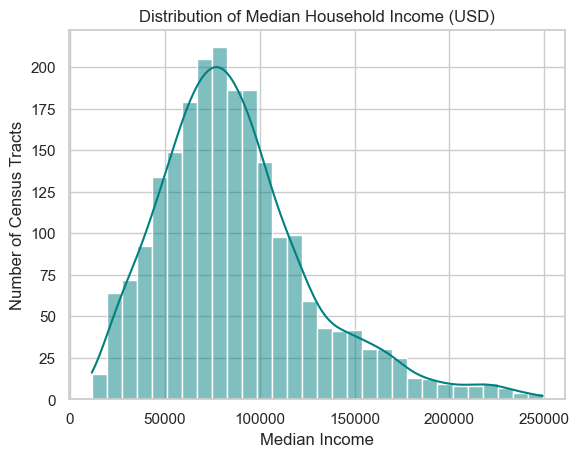

In [15]:
# Income summary
print("Income Summary:")
print(merged['Median_Income'].describe())

# Histogram
sns.histplot(merged['Median_Income'], bins=30, kde=True, color="teal")
plt.title("Distribution of Median Household Income (USD)")
plt.xlabel("Median Income")
plt.ylabel("Number of Census Tracts")
plt.show()


### 2. SEX / GENDER

Analyzing:
- % Male and % Female by tract
- Is there gender imbalance across tracts?
- Summary statistics

Gender Distribution Summary:
          Pct_Male   Pct_Female
count  2243.000000  2243.000000
mean     48.394965    51.605035
std       6.200259     6.200259
min      25.022042     0.000000
25%      45.032706    48.409844
50%      48.347770    51.652230
75%      51.590156    54.967294
max     100.000000    74.977958


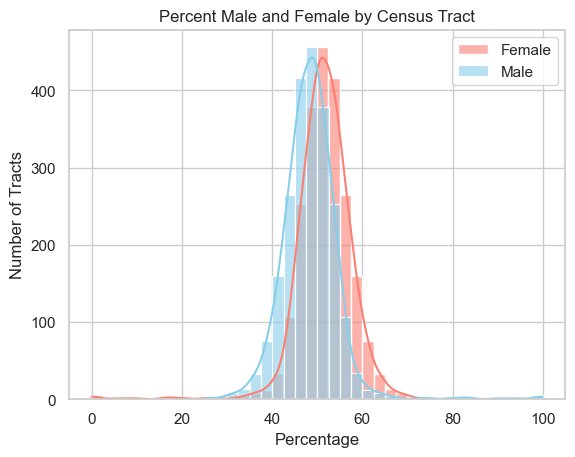

In [18]:
# Gender summary
print("Gender Distribution Summary:")
print(merged[['Pct_Male', 'Pct_Female']].describe())

# Histograms
sns.histplot(merged['Pct_Female'], bins=30, kde=True, color="salmon", label="Female", alpha=0.6)
sns.histplot(merged['Pct_Male'], bins=30, kde=True, color="skyblue", label="Male", alpha=0.6)
plt.title("Percent Male and Female by Census Tract")
plt.xlabel("Percentage")
plt.ylabel("Number of Tracts")
plt.legend()
plt.show()


### 3. RACE
Analyzing:
- % Black, % White distribution
- Racial composition variation across NYC
- Outlier tracts with racial concentration

Racial Composition Summary:
         Pct_Black    Pct_White
count  2243.000000  2243.000000
mean     23.674152    35.278632
std      27.161275    27.486529
min       0.000000     0.000000
25%       2.073845    10.064381
50%       9.769539    29.045997
75%      41.780160    58.903960
max     100.000000   100.000000


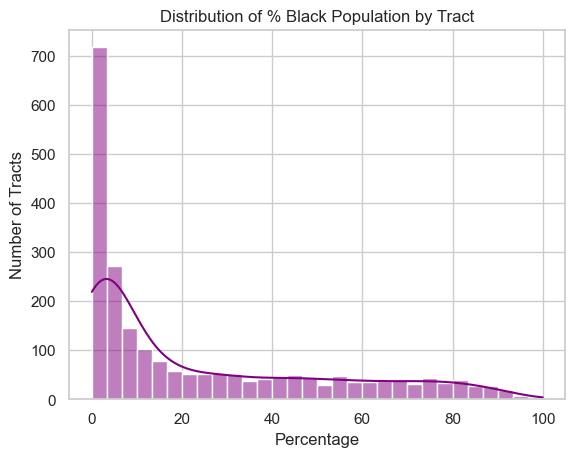

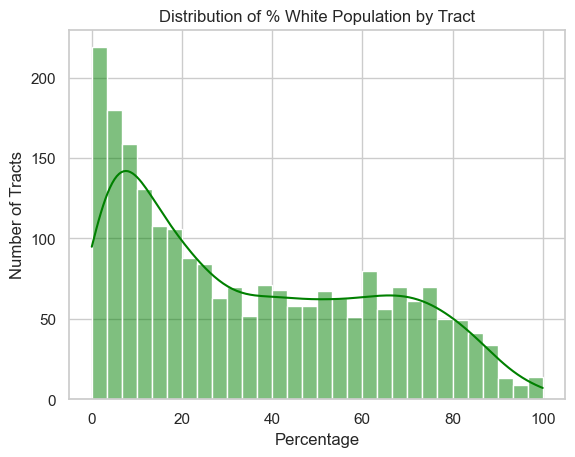

In [21]:
# Race summary
print("Racial Composition Summary:")
print(merged[['Pct_Black', 'Pct_White']].describe())

# Histograms
sns.histplot(merged['Pct_Black'], bins=30, kde=True, color="purple", label="Black")
plt.title("Distribution of % Black Population by Tract")
plt.xlabel("Percentage")
plt.ylabel("Number of Tracts")
plt.show()

sns.histplot(merged['Pct_White'], bins=30, kde=True, color="green", label="White")
plt.title("Distribution of % White Population by Tract")
plt.xlabel("Percentage")
plt.ylabel("Number of Tracts")
plt.show()

### 4. ETHNICITY (HISPANIC / NON-HISPANIC)

Analyzing:
- % Hispanic distribution
- Are there predominantly Hispanic tracts?
- What’s the range across NYC?

Hispanic/Latino Population Summary:
count    2243.000000
mean       73.043125
std        21.967346
min         0.000000
25%        60.886533
50%        80.394501
75%        89.862179
max       100.000000
Name: Pct_Hispanic, dtype: float64


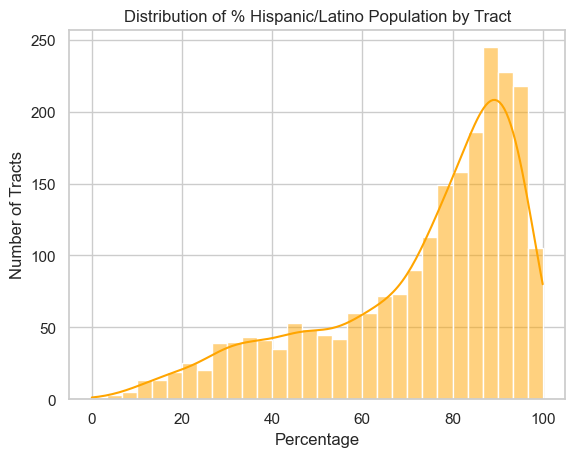

In [24]:
# Ethnicity summary
print("Hispanic/Latino Population Summary:")
print(merged['Pct_Hispanic'].describe())

# Histogram
sns.histplot(merged['Pct_Hispanic'], bins=30, kde=True, color="orange")
plt.title("Distribution of % Hispanic/Latino Population by Tract")
plt.xlabel("Percentage")
plt.ylabel("Number of Tracts")
plt.show()


### For age factor: senior citizens and students
- Senior citizens : defined by 65+
- Studdents : desined by 5-17 years old as per K-12 

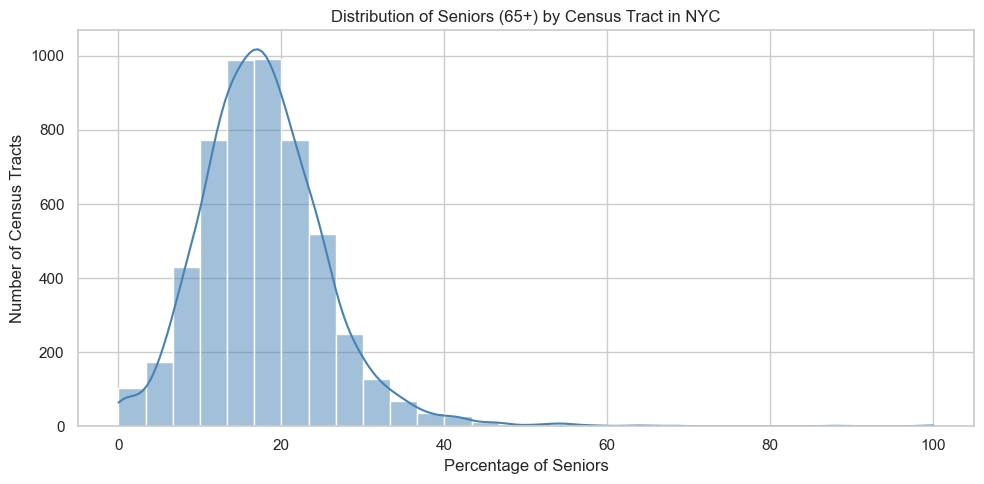

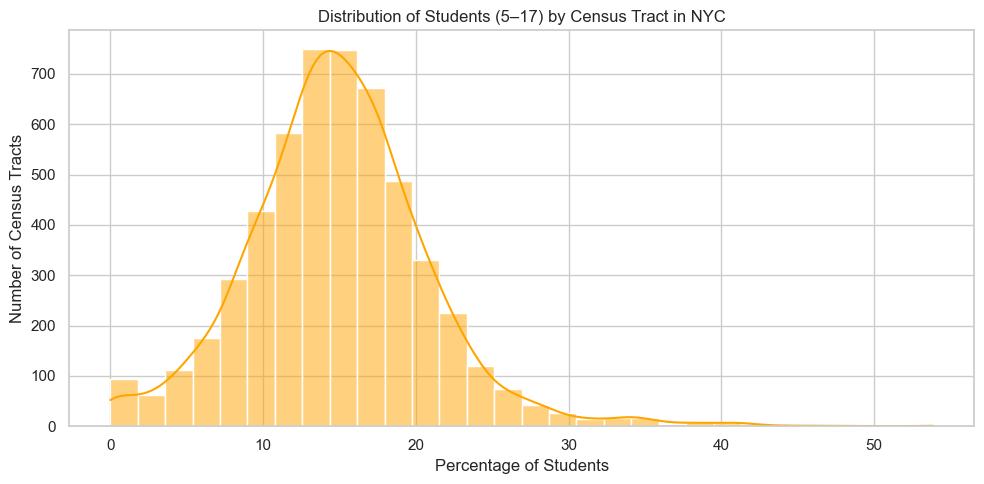

In [38]:
# Load the full B01001 detailed table
age_factor = pd.read_csv("/Users/kunjalbhatta/Desktop/Machine Learning for Cities/Final Project/Sex by age ACSDT5Y2023-3/ACSDT5Y2023.B01001-Data.csv")

# Define columns for seniors (65+) and students (5–17)
senior_cols = [
    'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E',
    'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E'
]

student_cols = [
    'B01001_004E', 'B01001_005E', 'B01001_006E',
    'B01001_028E', 'B01001_029E', 'B01001_030E'
]

# Convert to numeric
cols_to_convert = ['B01001_001E'] + senior_cols + student_cols
age_factor[cols_to_convert] = age_factor[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Compute totals
age_factor['Seniors_65plus'] = age_factor[senior_cols].sum(axis=1)
age_factor['Students_5to17'] = age_factor[student_cols].sum(axis=1)
age_factor['Total_Population'] = age_factor['B01001_001E']

# Compute percentages
age_factor['Pct_Seniors'] = (age_factor['Seniors_65plus'] / age_factor['Total_Population']) * 100
age_factor['Pct_Students'] = (age_factor['Students_5to17'] / age_factor['Total_Population']) * 100

# === Plot 1: Seniors ===
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(age_factor['Pct_Seniors'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Seniors (65+) by Census Tract in NYC")
plt.xlabel("Percentage of Seniors")
plt.ylabel("Number of Census Tracts")
plt.tight_layout()
plt.show()

# === Plot 2: Students ===
plt.figure(figsize=(10, 5))
sns.histplot(age_factor['Pct_Students'], bins=30, kde=True, color='orange')
plt.title("Distribution of Students (5–17) by Census Tract in NYC")
plt.xlabel("Percentage of Students")
plt.ylabel("Number of Census Tracts")
plt.tight_layout()
plt.show()
